In [1]:
%pylab inline
from genx import api

Populating the interactive namespace from numpy and matplotlib
'Plugin' object has no attribute 'data'


In [2]:
model, optimizer, refl=api.Reflectivity.create_new()

## Create Sample model
Ambient "Amb" and substrate "Sub" are already present in any model. Other layers are added to a new stack.
Parameters not supplied are set to default.

In [3]:
refl['Amb']=refl.Layer(dens=2.329*0.602214/28.0855, b='bc.Si')
refl.add_stack('ML')
refl.add_layer('SiO2', d=20.0, dens=3.0/113.005, b='bc.Si+2*bc.O', sigma=5.0)
refl.add_layer('Poly', d=260.0, dens=0.1, b=2.7, sigma=5.0)
refl['Sub']=refl.Layer(dens=1.107*0.602214/20.0276, b='bc.I2H*2+bc.O', sigma=5.0)

## Define instrument parameters

In [4]:
refl['inst'].coords='q'
refl['inst'].probe='neutron'
refl['inst'].restype='full conv and varying res.'
refl['inst'].Ibkg=3e-7
refl['inst'].I0=0.88

## Load the data
Set the calculation for resolution to take into account that column in file is FWHM and not sigma.

In [5]:
api.data_loader.resolution.LoadData(model.data[0], 'c_PLP0011859_q.txt')
model.data[0].extra_commands['res']='res/(2.*sqrt(2*log(2)))'
model.data[0].run_extra_commands()

Set the instrument resolution for this dataset to the resolution column.

In [6]:
refl.sim_exp[0].append('inst.setRes(data[0].res)')

## Write model into script
The representation of the refl model builder object shows the parameters used to build that script

In [7]:
refl.WriteModel()
refl

Reflectivity Model:
    Instruments:
        inst = Instrument(probe='neutron', wavelength=1.54, coords='q', I0=0.88, res=0.001, restype='full conv and varying res.', respoints=5, resintrange=2, beamw=0.01, footype='no corr', samplelen=10.0, incangle=0.5, pol='uu', Ibkg=3e-07, tthoff=0.0,)
    Sample Structure:
        Amb = model.Layer(sigma=0.0, dens=0.049938808495487, d=0.0, f=(1e-20+1e-20j), b=bc.Si, xs_ai=0.0, magn=0.0, magn_ang=0.0)
        ML = model.Stack: Repetitions = 1
        SiO2 = model.Layer(sigma=5.0, dens=0.026547497898323086, d=20.0, f=(1e-20+1e-20j), b=bc.Si+2*bc.O, xs_ai=0.0, magn=0.0, magn_ang=0.0)
        Poly = model.Layer(sigma=5.0, dens=0.1, d=260.0, f=(1e-20+1e-20j), b=2.7, xs_ai=0.0, magn=0.0, magn_ang=0.0)
        Sub = model.Layer(sigma=5.0, dens=0.0332866093790569, d=0.0, f=(1e-20+1e-20j), b=bc.I2H*2+bc.O, xs_ai=0.0, magn=0.0, magn_ang=0.0)
    User Parameters:
    Simulations:
        Data 0: Specular(d.x, inst)
            inst.setRes(data[0].res)

## Setup fit parameters
The model.parameters object has a list of parameter values. When added the default is the current value for the parameter and no fit. Parameters can later be accessed with model.parameters[i].

In [8]:
model.parameters.append('SiO2.setD', model).fit=True
model.parameters.append('SiO2.setSigma', model).fit=True
model.parameters.append('Poly.setD', model).fit=True
model.parameters.append('Poly.setSigma', model).fit=True
model.parameters.append('Poly.setDens', model).fit=True
model.parameters.append('Sub.setSigma', model).fit=True

Model has to be simulated once before fitting. The refl object includes a Jupyter widget for simulating and adjusting parameters.

In [9]:
model.simulate()
# Uncomment the following line to show the Jupyter widget for interactive controls
#refl.widget

## Refine the parameters
The api.fit_notebook function, in contrast to api.fit, gives regular updates on the Notebook for interactive display of the progress.

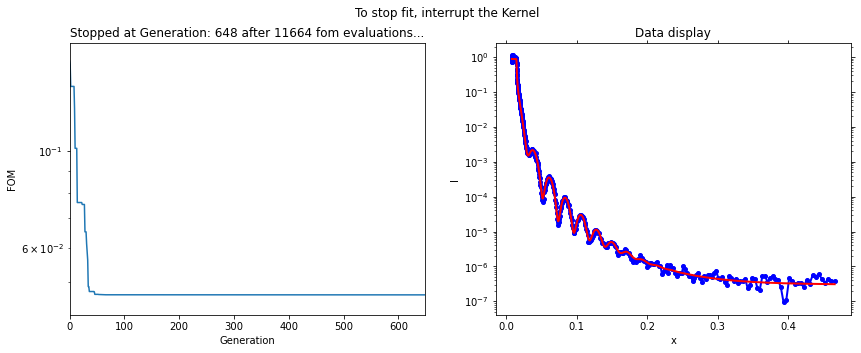

Stopped at Generation: 648 after 11664 fom evaluations...
If you want to update the model with the fit results, call api.fit_update(model, optimizer)


In [10]:
optimizer.sleep_time=0.0
api.fit_notebook(model, optimizer)

Put the fit parameters into the model

In [11]:
api.fit_update(model, optimizer)

## Show a summary for the results

Genx Model - compiled
File: 
Parameters:
           Parameter        Value            Fit              Min              Max              Error           
                            0.0              False            0.0              0.0              None            
           SiO2.setD        27.092197233372637 True             5.0              80.0             None            
           SiO2.setSigma    11.190916175221927 True             1.25             20.0             None            
           Poly.setD        266.47578659215344 True             65.0             1040.0           None            
           Poly.setSigma    14.705276465985197 True             1.25             20.0             None            
           Poly.setDens     0.09161458233568151 True             0.025            0.4              None            
           Sub.setSigma     2.6949603565665967 True             1.25             20.0             None            
DataList([
           DataSet(name=Data 0         , show=True, use=True, error=False),
           ])
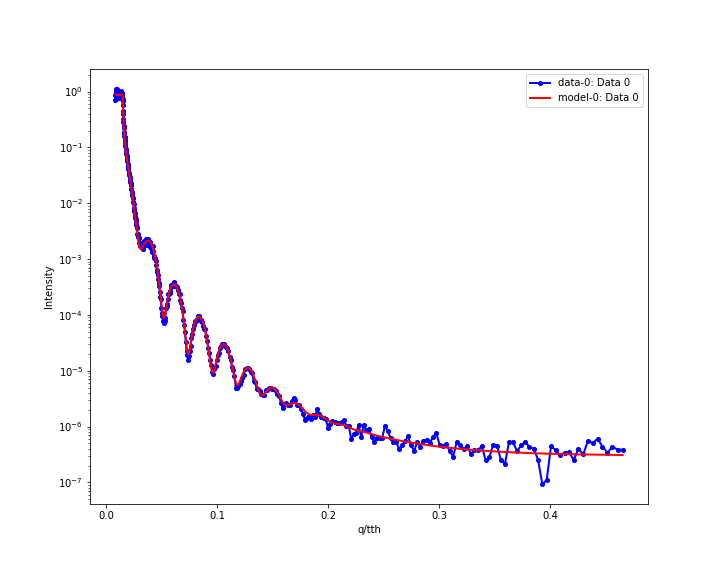

In [12]:
model

In [13]:
# Uncomment the following line to save the result to a GenX file that can be loaded in the GUI
# api.save('example.hgx', model, optimizer)

## Run the model through MCMC with bumps to quantify error statistics

In [14]:
import warnings

from bumps.fitters import LevenbergMarquardtFit, DEFit, fit, FIT_ACTIVE_IDS
from bumps.dream.views import *

warnings.filterwarnings('ignore')

In [15]:
res=model.bumps_fit(method='dream',  pop=15, samples=5e4, burn=100, thin=1, alpha=0, outliers='none', 
                         trim=False, verbose=True)

# steps: 556, # draws: 50040


              Parameter       mean  median    best [   68% interval] [   95% interval]
 1               Poly_D 267.15(29) 267.152 267.150 [ 266.86  267.43] [ 266.60  267.73]
 2            Poly_Dens 0.09174(37) 0.09175 0.09181 [ 0.0914  0.0921] [ 0.0910  0.0925]
 3           Poly_Sigma  14.21(37)  14.196  14.135 [  13.85   14.57] [  13.47   14.94]
 4               SiO2_D  26.11(30)  26.120  26.086 [  25.80   26.41] [  25.50   26.67]
 5           SiO2_Sigma  11.36(28)  11.359  11.395 [  11.08   11.65] [  10.82   11.93]
 6            Sub_Sigma  3.043(98)   3.044   3.040 [   2.94    3.14] [   2.84    3.24]

Statistics and plots based on 50490 samples (100.0% of total samples drawn)


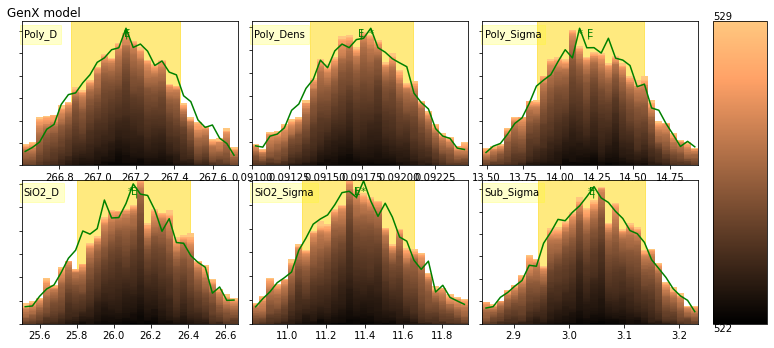

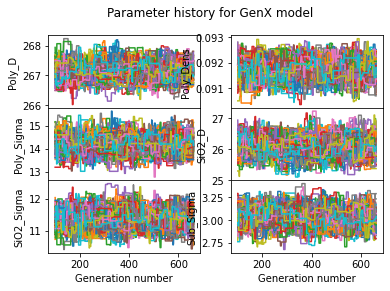

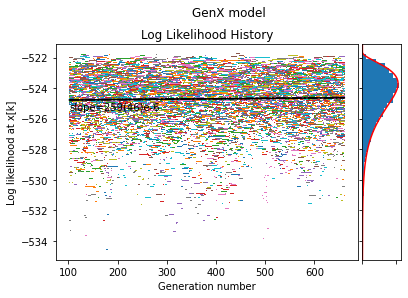

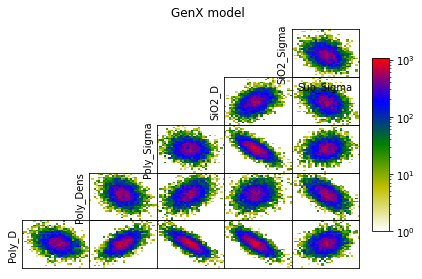

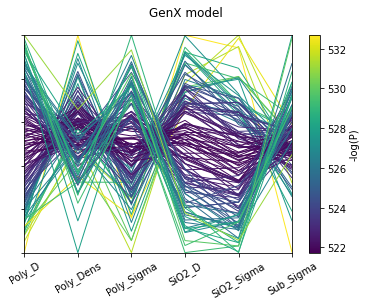

In [16]:
plot_all(res.state)